##Table of contents

1.   Introduction

    *   Abstract
    *   Workspace config
    *   Preparation of workspace
    *   Train/test split

2.   Dataset summary

    *   Dataset sample image
    *   Dataset categorical statistics

3.   Training

    *   ResNet50 training pipeline
    *   EfficientNetB4 training pipeline


4.   Evaluation

    *   ResNet50 model evaluation
    *   EfficientNetB4 model evaluation
    *   Model comparison


5.   Prediction on new images

    *   ResNet50 prediction
    *   EfficientNetB4 prediction


6.   Summary



#1. Introduction



The aim for the project is classification of waste type among 5 categories: cardboard, glass, metal, paper, plastic. It is a final project for Data Science Bootcamp certified by Sages.

##Abstract

Waste segregation is a huge issue in a modern world, where consumptionism is a basic mechanism in a social functioning. Although ecological movements are founded and pushed, new trends like 'no waste' are being defined and the awareness of responsibility for our planet is drilled into new generations, we still need to encouter decades of produced waste, a legacy of our grandparents and parents.

This task is however ideal to be addressed with modern technology. Robotics and deep learning are separate fields that mix well. And the state-of-the-art solutions known nowadays are all set to solve waste segregation dilemma.

This project is a preliminary research for solutions that can be developed for the case. Its purpose is to raise awareness of what modern technology is capable of and how it can be achieved. It is not a SoA approach intended to be commisioned to the production.

Two Convolutional Neural Networks are trained and evaluated - ResNet50 (2015) and EfficientNetB4 (2019). The idea is to use transfer learning and achieve promising results with popular and free tools - Python, Tensorflow, Kaggle datasets and Google Colab. The goal is to develop a working CNN model, that solves the classification problem of waste in 5 categories: cardboard, glass, paper, metal and plastic.

##Workspace config

Computations were executed in Google Colaboratory environment with Nvidia Tesla V100 GPU.

In [ ]:
!python --version

Python 3.7.11


In [ ]:
!nvidia-smi

Mon Aug 16 20:25:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preparation of workspace

Google Drive disk will be mounted as storage space for dataset images. Google One is needed in order to provide resources for read/write of CNN models (~5GB model size).

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/bootcamp_project')

In [ ]:
import matplotlib.pyplot as plt
import shutil
from custom_model import CustomModel 
from training_pipe import TrainingPipe  
from model_evaluator import ModelEvaluator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as ResNet_preprocess_function
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input as EfficientNet_preprocess_function
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

##Train/test split

Train/test samples available in *The Garbage Classification Dataset* were merged and split customly, so that each category has 100 samples for testing.

In [ ]:
DATASET_DIR = 'garbage/train'

In [ ]:
# Split train/test
categories = [dir.split('/')[-1] for dir, _, files in os.walk(DATASET_DIR)][1:]
for category in categories:
  print(category)
  for file in os.listdir(f'garbage/train/{category}')[:100]:
    shutil.move(f'garbage/train/{category}/'+file, f'garbage/test/{category}/'+file)

plastic
metal
cardboard
paper
glass


# 2. Dataset summary

The Garbage Classification Dataset contains 6 classifications: cardboard (403), glass (503), metal (410), paper (894), plastic (482) and trash(127).

https://www.kaggle.com/asdasdasasdas/garbage-classification


'trash' category samples were dropped out as it contains significantly less samples than other categories and does not provide useful information in waste sergregation process.

In [ ]:
TRAIN_DATA_DIR = 'garbage/train'
TEST_DATA_DIR = 'garbage/test'

In [ ]:
train_categories_count = sorted([(dir.split('/')[-1], len(files)) for dir, _, files in os.walk(TRAIN_DATA_DIR)][1:])
test_categories_count = sorted([(dir.split('/')[-1], len(files)) for dir, _, files in os.walk(TEST_DATA_DIR)][1:])

##Dataset sample image

Train/test division was rearranged so that each category contains 100 samples for testing. This results in ~20% train/test split size.

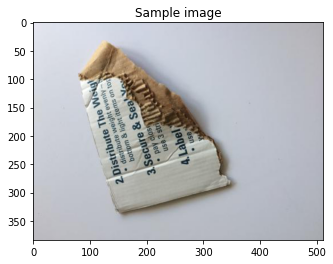

--------------------
Image shape: (384, 512, 3)
--------------------
Min image value: 0.0
Max image value: 255.0
--------------------
Train samples count: 1890
Test samples count: 500
--------------------
Test size: 20.92 % 



In [ ]:
sample_image = load_img(os.path.join(TRAIN_DATA_DIR,'cardboard/cardboard143.jpg'))
image_arr = img_to_array(sample_image)

plt.imshow(sample_image)
plt.title('Sample image')
plt.show()

subsection='-'*20
train_samples_count=sum([x for _,x in train_categories_count])
test_samples_count=sum([x for _,x in test_categories_count])

print(f'''{subsection}
Image shape: {image_arr.shape}
{subsection}
Min image value: {image_arr.min()}
Max image value: {image_arr.max()}
{subsection}
Train samples count: {train_samples_count}
Test samples count: {test_samples_count}
{subsection}
Test size: {round((test_samples_count / (train_samples_count + test_samples_count))*100, 2)} % 
''')

##Dataset categorical statistics

Count of samples in each category in the training dataset is similar. Data augmenation will be used in order to generate more samples for learning process.

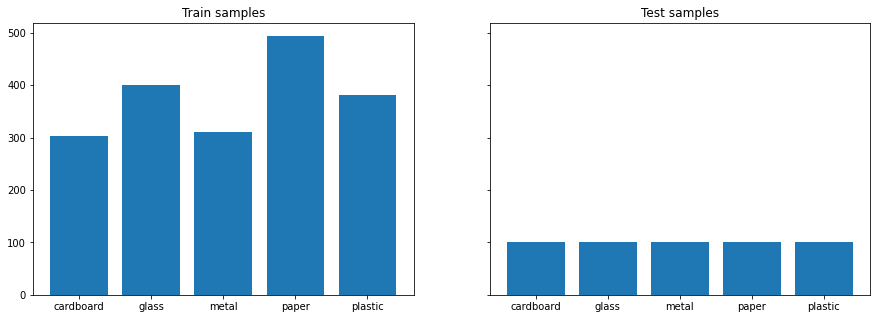

In [ ]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2, sharey=True)

ax[0].bar(x=[x for x,_ in train_categories_count],
          height=[x for _,x in train_categories_count])
ax[0].set_title('Train samples')

ax[1].bar(x=[x for x,_ in test_categories_count],
          height=[x for _,x in test_categories_count])
ax[1].set_title('Test samples')

plt.show()

# 3. Training

Two well known CNN architectures will be trained: ResNet50 (2015) and EfficientNetB4 (2019). Pre-trained models available in Keras repository will be used in order to shorten training time and computation power. Models' weights were computed on *imagenet* dataset and both use specific preprocess functions for transfer learning. These functions are also available in Keras lib.

The idea is to prepare and evatuate 2 phases of transfer learning separetly. The first one is learning with frozen convolutional part, so that only decission part will get trained. In phase two the convolutional part will be enabled for fine-tuning and all trainable NN parameters will be computed.

The data augmentation parameters are hard-coded in the TrainingPipe class. Keras ImageGenerator is used in order to deliver batch flow from Google Drive storage to the learning process. It is also used for epoch evaluation (20% samples among training set).

In order to optimize learning process EarlyStopping was used in both phases.

All the process parameters are defined here below or fixed in TrainingPipe class.

In [ ]:
TRAIN_DATA_DIR = 'garbage/train'
BATCH_SIZE = 16
EPOCHS_TRANSFER_LEARNING = 600
PATIENCE_TRANSFER_LEARNING = 30
EPOCHS_FINE_TUNING = 150
PATIENCE_FINE_TUNING = 15
VAL_SIZE = 0.2
N_CATEGORIES = 5
IMAGE_SHAPE = (384, 512, 3)
TOP_HIDDEN_LAYERS_RESNET = (1500, 700, 100)
TOP_HIDDEN_LAYERS_EFFICIENTNET = (1200, 500, 80)
DROPOUT = 0.25

## ResNet50

In [ ]:
pipeline = TrainingPipe(image_shape=IMAGE_SHAPE,
                        batch_size=BATCH_SIZE)

pipeline.prepare_data_generator(data_dir=TRAIN_DATA_DIR,
                                preprocessing_function=ResNet_preprocess_function)

Found 1514 images belonging to 5 classes.
Found 376 images belonging to 5 classes.


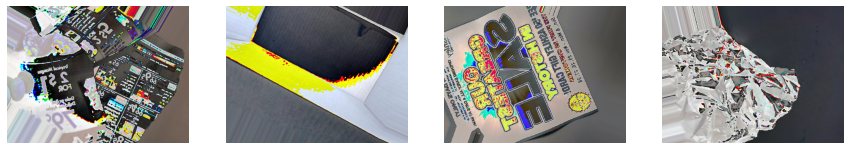

In [ ]:
pipeline.show_samples()

In [ ]:
resnet_model = ResNet50(weights="imagenet", 
                        include_top=False, 
                        input_shape=IMAGE_SHAPE)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model = CustomModel(base_model=resnet_model,
                    top_hidden_layers=TOP_HIDDEN_LAYERS_RESNET,
                    activation='sigmoid',
                    n_classes=N_CATEGORIES,
                    dropout=DROPOUT).get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 12, 16, 2048)      23587712  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 590946805 
Total params: 614,534,517
Trainable params: 614,481,397
Non-trainable params: 53,120
_________________________________________________________________


Epoch 1/600
94/94 [==============================] - 521s 5s/step - loss: 1.2715 - accuracy: 0.4473 - val_loss: 1.1374 - val_accuracy: 0.5346
Epoch 2/600
94/94 [==============================] - 99s 1s/step - loss: 0.9029 - accuracy: 0.5854 - val_loss: 1.1556 - val_accuracy: 0.5213
Epoch 3/600
94/94 [==============================] - 99s 1s/step - loss: 0.8408 - accuracy: 0.6282 - val_loss: 1.0986 - val_accuracy: 0.5452
Epoch 4/600
94/94 [==============================] - 100s 1s/step - loss: 0.8077 - accuracy: 0.6503 - val_loss: 1.0471 - val_accuracy: 0.5479
Epoch 5/600
94/94 [==============================] - 100s 1s/step - loss: 0.8115 - accuracy: 0.6422 - val_loss: 1.2612 - val_accuracy: 0.4920
Epoch 6/600
94/94 [==============================] - 100s 1s/step - loss: 0.8075 - accuracy: 0.6529 - val_loss: 1.2155 - val_accuracy: 0.5452
Epoch 7/600
94/94 [==============================] - 99s 1s/step - loss: 0.7719 - accuracy: 0.6809 - val_loss: 1.0173 - val_accuracy: 0.5612
Epoch 8/6

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: training/models/ResNet50/assets
Epoch 1/150
94/94 [==============================] - 139s 1s/step - loss: 0.9458 - accuracy: 0.6262 - val_loss: 0.9717 - val_accuracy: 0.6436
Epoch 2/150
94/94 [==============================] - 97s 1s/step - loss: 0.7598 - accuracy: 0.7123 - val_loss: 1.0406 - val_accuracy: 0.6543
Epoch 3/150
94/94 [==============================] - 96s 1s/step - loss: 0.6425 - accuracy: 0.7377 - val_loss: 0.9890 - val_accuracy: 0.6436
Epoch 4/150
94/94 [==============================] - 96s 1s/step - loss: 0.6558 - accuracy: 0.7517 - val_loss: 0.9825 - val_accuracy: 0.6489
Epoch 5/150
94/94 [==============================] - 96s 1s/step - loss: 0.5986 - accuracy: 0.7690 - val_loss: 0.9958 - val_accuracy: 0.6383
Epoch 6/150
94/94 [==============================] - 95s 1s/step - loss: 0.5788 - accuracy: 0.7837 - val_loss: 0.9934 - val_accuracy: 0.6489
Epoch 7/150
94/94 [==============================] - 95s 1s/step - loss: 0.5687 - accu

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: training/models/ResNet50_fine_tuning/assets





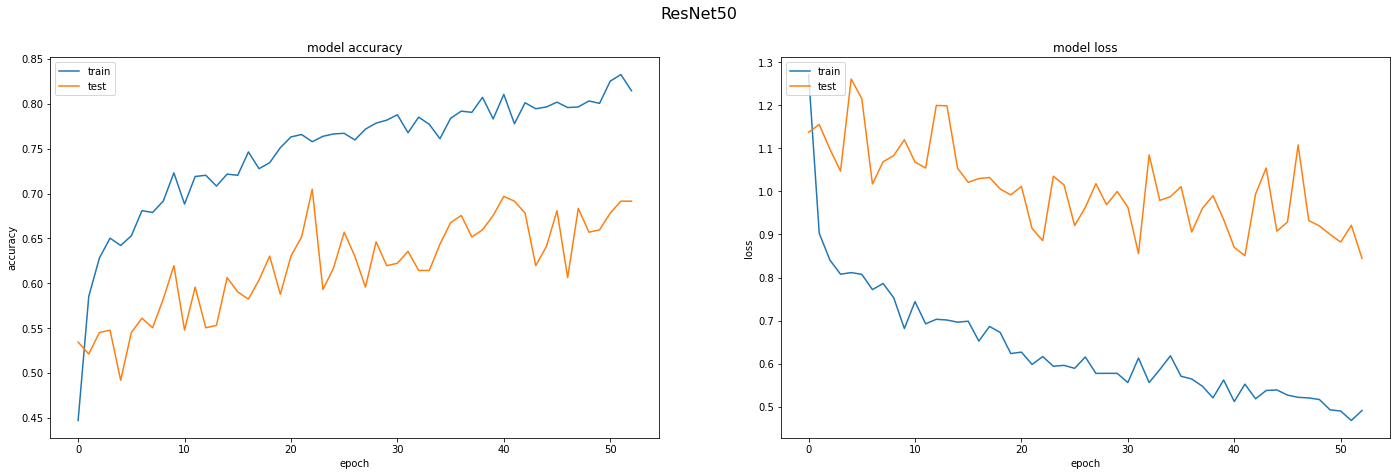

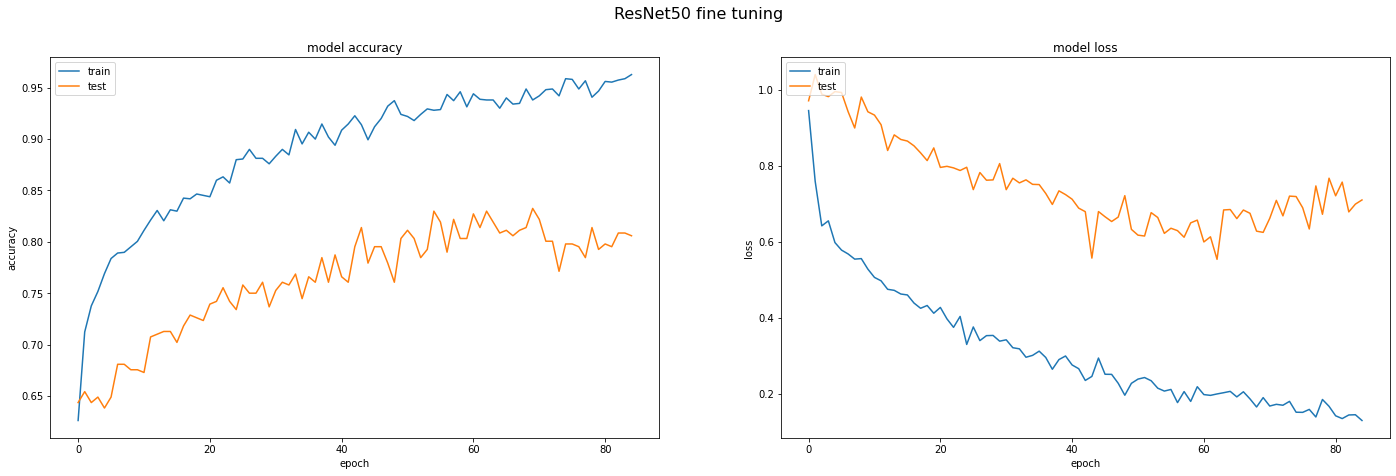

In [ ]:
pipeline.train_model_auto(model_name='ResNet50', 
                          model=model,
                          epochs=EPOCHS_TRANSFER_LEARNING,
                          patience=PATIENCE_TRANSFER_LEARNING,
                          save_freq=20,
                          with_fine_tuning=True,
                          epochs_ft=EPOCHS_FINE_TUNING,
                          patience_ft=PATIENCE_FINE_TUNING,
                          save_freq_ft=5)

Training history plots for ResNet50 training process show that fine-tuning phase is significant for the model performance. It allowed to enhance model fitting from ~80% to nearly 95%, resulting in eval accuracy enhancement from 70% to 80%. The accuracy improvement succeeds continuously until EarlyStopping stops the process. 

## EfficienNetB4

In [ ]:
pipeline = TrainingPipe(image_shape=IMAGE_SHAPE,
                        batch_size=BATCH_SIZE)

pipeline.prepare_data_generator(data_dir=TRAIN_DATA_DIR, 
                                preprocessing_function=EfficientNet_preprocess_function)

Found 1514 images belonging to 5 classes.
Found 376 images belonging to 5 classes.


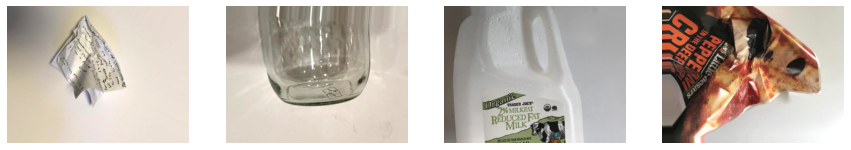

In [ ]:
pipeline.show_samples()

In [ ]:
efficientnet_model = EfficientNetB4(weights="imagenet", 
                                    include_top=False, 
                                    input_shape=IMAGE_SHAPE)

In [ ]:
model = CustomModel(base_model=efficientnet_model,
                    top_hidden_layers=TOP_HIDDEN_LAYERS_EFFICIENTNET,
                    activation='sigmoid',
                    n_classes=N_CATEGORIES,
                    dropout=DROPOUT).get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 12, 16, 1792)      17673823  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 413518985 
Total params: 431,192,808
Trainable params: 431,067,601
Non-trainable params: 125,207
_________________________________________________________________


Epoch 1/600
94/94 [==============================] - 105s 998ms/step - loss: 1.3221 - accuracy: 0.4640 - val_loss: 1.1784 - val_accuracy: 0.6170
Epoch 2/600
94/94 [==============================] - 90s 959ms/step - loss: 1.0447 - accuracy: 0.6782 - val_loss: 1.0539 - val_accuracy: 0.7074
Epoch 3/600
94/94 [==============================] - 93s 990ms/step - loss: 0.9164 - accuracy: 0.7684 - val_loss: 0.9843 - val_accuracy: 0.7101
Epoch 4/600
94/94 [==============================] - 92s 975ms/step - loss: 0.8128 - accuracy: 0.8218 - val_loss: 0.8906 - val_accuracy: 0.7819
Epoch 5/600
94/94 [==============================] - 92s 976ms/step - loss: 0.7461 - accuracy: 0.8451 - val_loss: 0.8353 - val_accuracy: 0.7713
Epoch 6/600
94/94 [==============================] - 92s 982ms/step - loss: 0.6563 - accuracy: 0.8865 - val_loss: 0.7834 - val_accuracy: 0.7819
Epoch 7/600
94/94 [==============================] - 92s 982ms/step - loss: 0.6112 - accuracy: 0.8932 - val_loss: 0.7717 - val_accuracy

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: training/models/EfficientNetB4/assets





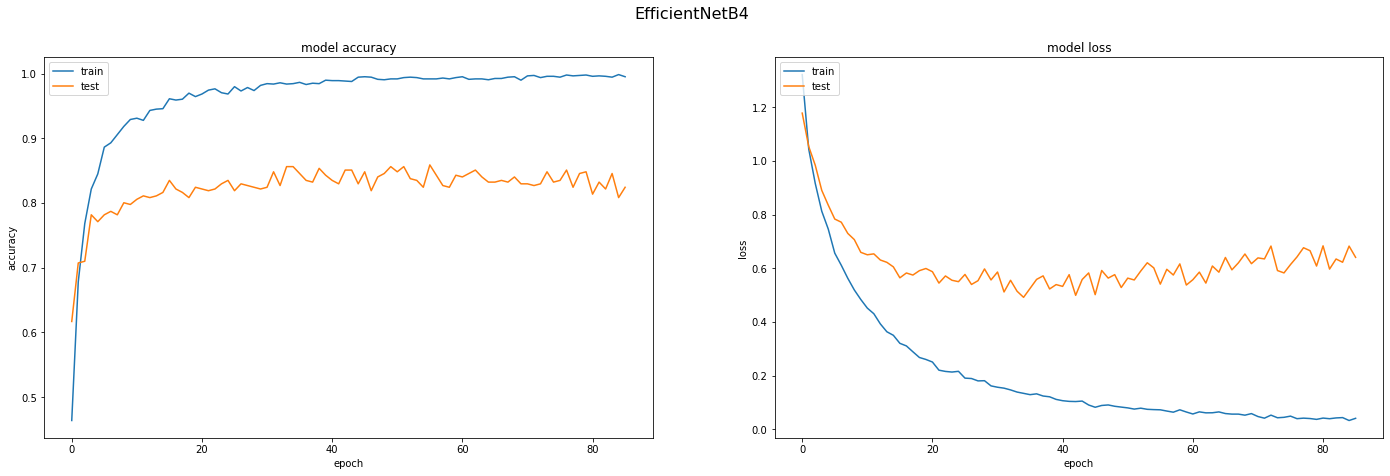

In [ ]:
pipeline.train_model(model_name='EfficientNetB4', 
                     model=model,
                     epochs=EPOCHS_TRANSFER_LEARNING,
                     patience=PATIENCE_TRANSFER_LEARNING,
                     save_freq=20,
                     fine_tuning=False)

The characteristics for EfficientNet learning process unveils that it is clearly more efficient than the one for ResNet. The model fitting close to ideal 100% was achieved rapidly in 30 epochs only. As the result fine-tuning of the model will not provide further improvement, so that it is not performed.

However model accuracy remains at ~80% and loss function flattens. Further accuracy improvement is a matter of data quality rather than network structure itself - the restriction here is number of samples in dataset and data augmentation.

# 4. Evaluation

In [ ]:
TEST_DATA_DIR = 'garbage/test'

## ResNet50

In [ ]:
resnet_model = load_model('training/models/ResNet50')

In [ ]:
resnet_evaluator = ModelEvaluator(model=resnet_model)
resnet_evaluator.prepare_data_generator(data_dir=TEST_DATA_DIR)

resnet_evaluator.accuracy_score()

Found 500 images belonging to 5 classes.
Model accuracy score: 0.658


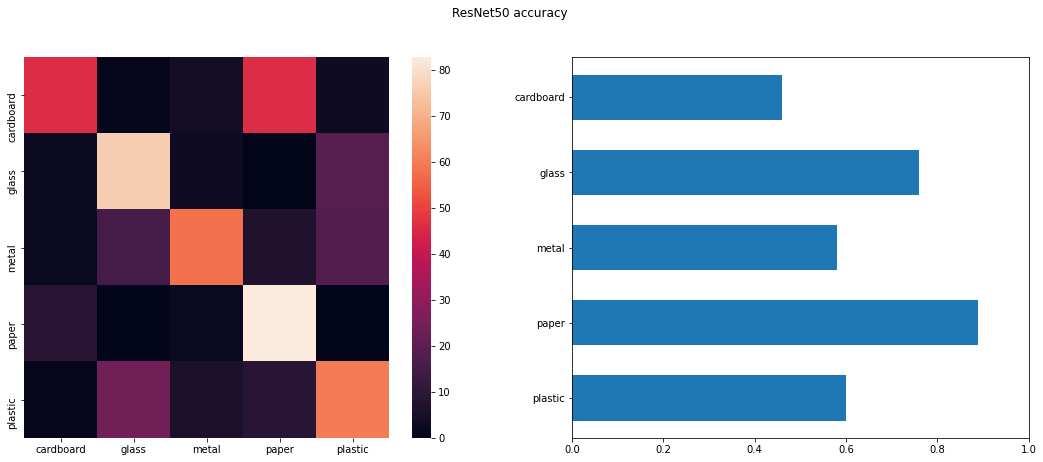

In [ ]:
resnet_evaluator.confusion_matrix_categorical_accuracy(title='ResNet50 accuracy')

In [ ]:
resnet_ft_model = load_model('training/models/ResNet50_fine_tuning')

In [ ]:
resnet_ft_evaluator = ModelEvaluator(model=resnet_ft_model)
resnet_ft_evaluator.prepare_data_generator(data_dir=TEST_DATA_DIR)

resnet_ft_evaluator.accuracy_score()

Found 500 images belonging to 5 classes.
Model accuracy score: 0.678


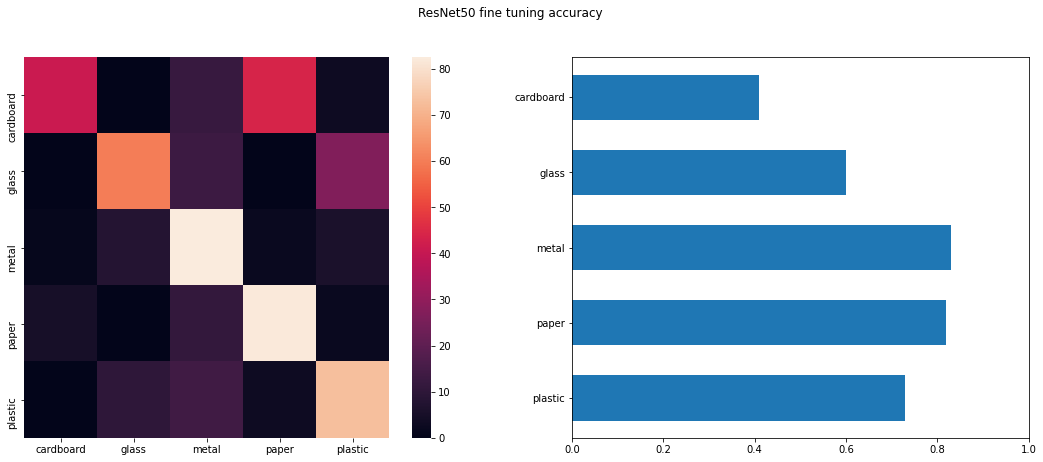

In [ ]:
resnet_ft_evaluator.confusion_matrix_categorical_accuracy(title='ResNet50 fine tuning accuracy')

ResNet50 accuracy reaches 66-68% on the testing set. The largest group (paper) contains 25% samples. That means the model works, if the largest class count was to be considered a referencing point. On the other hand the total score is not impressive. 

What may be noticed, the categorical accuracy score distribution is different among models with and without fine-tuning.

## EfficienNetB4

In [ ]:
efficientnet_model = load_model('training/models/EfficientNetB4')

In [ ]:
efficientnet_evaluator = ModelEvaluator(model=efficientnet_model)
efficientnet_evaluator.prepare_data_generator(data_dir=TEST_DATA_DIR)

efficientnet_evaluator.accuracy_score()

Found 500 images belonging to 5 classes.
Model accuracy score: 0.898


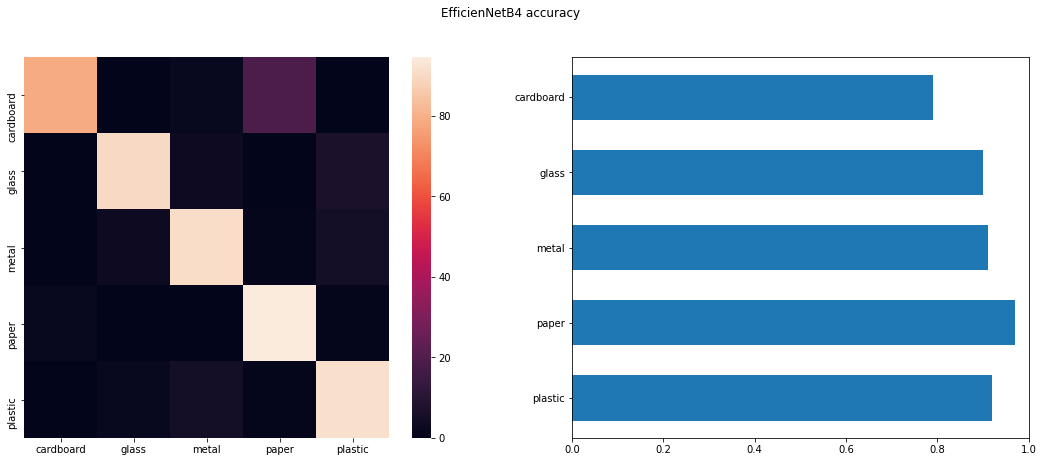

In [ ]:
efficientnet_evaluator.confusion_matrix_categorical_accuracy(title='EfficienNetB4 accuracy')

Overall accuracy score reaches 90%, which looks far better than the one obtained with ResNet. Moreover the training process was more efficient. The diagonal of confusion matrix is explicit and categorical accuracy of each category is similar one to another.

## Model comparison

In [ ]:
df_good, df_misclasified = ModelEvaluator.categorical_classification([('ResNet50_fine _tuning', resnet_ft_evaluator),
                                                                      ('EfficientNetB4',efficientnet_evaluator)])

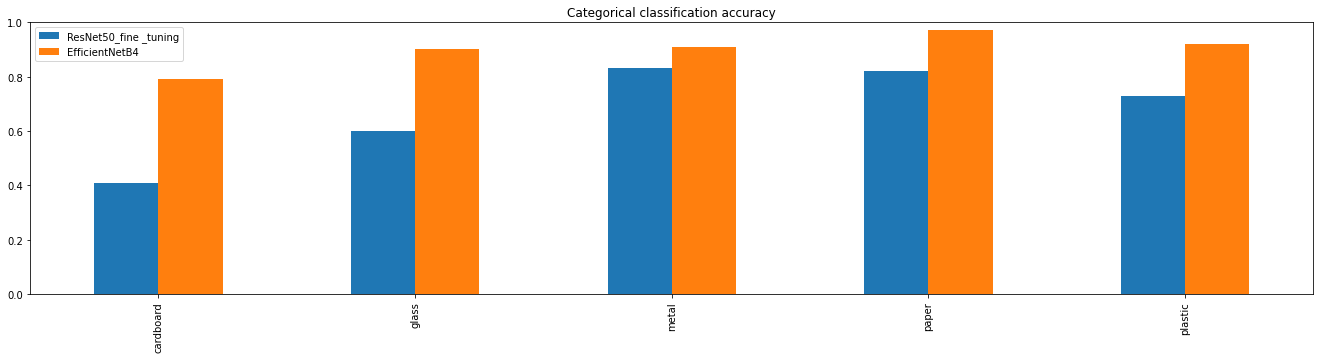

In [ ]:
_ = df_good.plot.bar(figsize=(23,5), title='Categorical classification accuracy', ylim=[0,1])

EfficientNet had better outcome in each category classification accuracy score. The biggest difference occurs for carbdoard and glass.

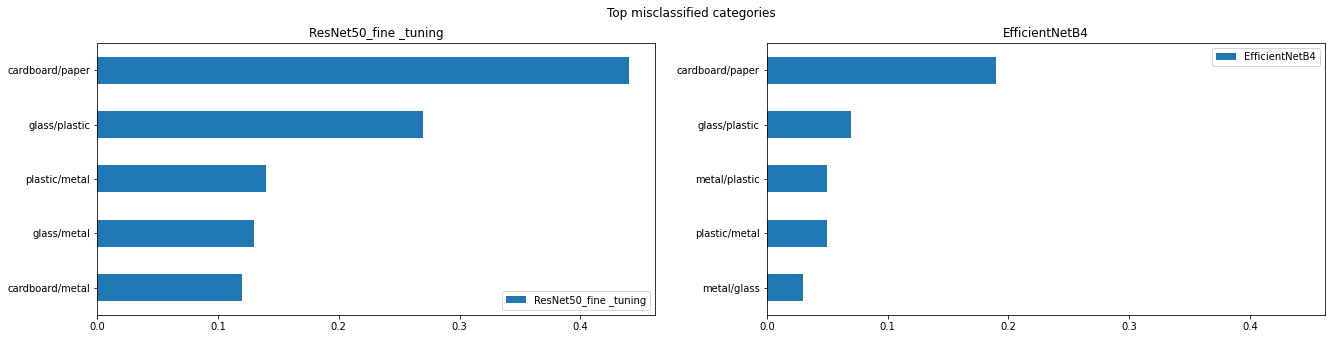

In [ ]:
fig, ax = plt.subplots(figsize=(22,5), nrows=1, ncols=2, sharex=True)
plt.suptitle('Top misclassified categories')
df_misclasified[['ResNet50_fine _tuning']].sort_values(by=['ResNet50_fine _tuning'], ascending=False).head()[::-1].plot.barh(ax=ax[0])
ax[0].set_title('ResNet50_fine _tuning')
df_misclasified[['EfficientNetB4']].sort_values(by=['EfficientNetB4'], ascending=False).head()[::-1].plot.barh(ax=ax[1])
ax[1].set_title('EfficientNetB4')
plt.show()

Top missclassified categories are pretty similar in both models. Missclassification of paper and cardboard is not surprising and may not be considered as error in waste seggregation process.

Glass/plastic missclassification is also pretty obvious, as bottles of both materials look similar.

Better performance of EfficientNet compared to ResNet in top missclassified categories is significant.

# 5. Prediction on sample images

In [ ]:
SAMPLE_DATA_DIR = 'garbage/test'

##ResNet50

In [ ]:
resnet_ft_model = load_model('training/models/ResNet50_fine_tuning')

Found 500 images belonging to 5 classes.


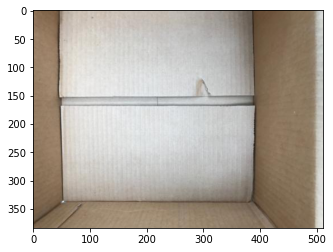

,probability
cardboard,97.510002
paper,2.410000
metal,0.040000
plastic,0.030000
glass,0.000000


In [ ]:
ModelEvaluator.predict_for_image(model=resnet_ft_model,
                                 preprocessing_function=ResNet_preprocess_function,
                                 data_dir=SAMPLE_DATA_DIR,
                                 img_path='cardboard/cardboard102.jpg')

Found 500 images belonging to 5 classes.


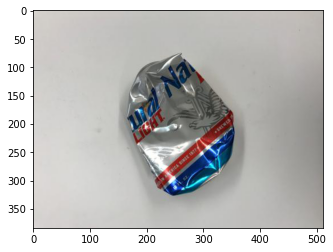

,probability
metal,82.599998
plastic,11.020000
paper,4.820000
glass,1.520000
cardboard,0.030000


In [ ]:
ModelEvaluator.predict_for_image(model=resnet_ft_model,
                                 preprocessing_function=ResNet_preprocess_function,
                                 data_dir=SAMPLE_DATA_DIR,
                                 img_path='metal/metal102.jpg')

Found 500 images belonging to 5 classes.


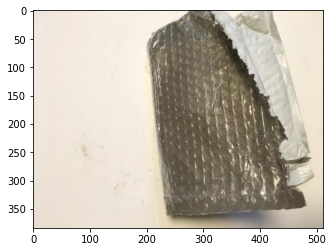

,probability
metal,64.669998
plastic,23.450001
glass,10.030000
paper,1.750000
cardboard,0.100000


In [ ]:
ModelEvaluator.predict_for_image(model=resnet_ft_model,
                                 preprocessing_function=ResNet_preprocess_function,
                                 data_dir=SAMPLE_DATA_DIR,
                                 img_path='plastic/plastic457.jpg')

##EfficienNetB4

In [ ]:
efficientnet_model = load_model('training/models/EfficientNetB4')

Found 500 images belonging to 5 classes.


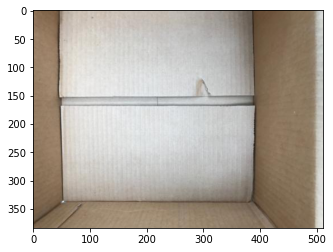

,probability
cardboard,95.220001
glass,2.040000
paper,1.030000
metal,0.950000
plastic,0.770000


In [ ]:
ModelEvaluator.predict_for_image(model=efficientnet_model,
                                 preprocessing_function=ResNet_preprocess_function,
                                 data_dir=SAMPLE_DATA_DIR,
                                 img_path='cardboard/cardboard102.jpg')

Found 500 images belonging to 5 classes.


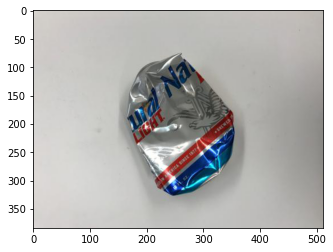

,probability
plastic,69.970001
metal,19.350000
paper,7.900000
cardboard,1.920000
glass,0.860000


In [ ]:
ModelEvaluator.predict_for_image(model=efficientnet_model,
                                 preprocessing_function=ResNet_preprocess_function,
                                 data_dir=SAMPLE_DATA_DIR,
                                 img_path='metal/metal102.jpg')

Found 500 images belonging to 5 classes.


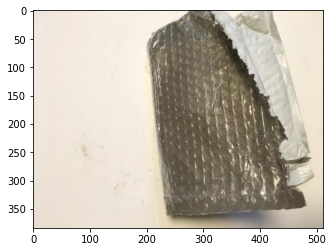

,probability
plastic,58.139999
metal,30.629999
paper,8.720000
glass,1.440000
cardboard,1.080000


In [ ]:
ModelEvaluator.predict_for_image(model=efficientnet_model,
                                 preprocessing_function=ResNet_preprocess_function,
                                 data_dir=SAMPLE_DATA_DIR,
                                 img_path='plastic/plastic457.jpg')

# 6. Summary

The goal for the project was achieved succesfully.